In [1]:
import yfinance as yf
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
companies=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
table  = companies[0]
#the below code removes tickers that have no data (from previous experience)
df = table[table["Symbol"].str.contains("BRK.B|BF.B") == False]
ticker_list = df['Symbol'].to_list()

In [3]:
def betas(markets, stocks, start_date, end_date):
#download the historical data for the index/market
  market = yf.download(markets, start_date, end_date)
  market['stock_name'] = markets
#calculate daily returns 
  market['daily_return'] = market['Close'].pct_change(1)
#calculate standard deviation of the returns
  market_std = market['daily_return'].std()
  market.dropna(inplace=True)
  market = market[['Close', 'stock_name', 'daily_return']] 
#download the historical data for each stock and calculate its standard deviation 
#using for loops/iteration 
  frames = []
  stds = []
  for i in stocks: 
    data = yf.download(i, start_date, end_date)
    data['stock_name'] = i
    data['daily_return'] = data['Close'].pct_change(1)
    data.dropna(inplace=True)
    data = data[[ 'Close', 'stock_name', 'daily_return']]
    data_std = data['daily_return'].std()
    frames.append(data)
    stds.append(data_std)
#for each stock calculate its correlation with index/market 
  stock_correlation = []
  for i in frames: 
    correlation = i['daily_return'].corr(market['daily_return'])
    stock_correlation.append(correlation)
#calculate beta 
  betas = []
  for b,i in zip(stock_correlation, stds):
    beta_calc = b * (i/market_std)
    betas.append(beta_calc)
#form dataframe with the results 
  dictionary = {stocks[e]: betas[e] for e in range(len(stocks))}
  dataframe = pd.DataFrame([dictionary]).T
  dataframe.reset_index(inplace=True)
  dataframe.rename(
    columns={"index": "Stock_Name", 0: "Beta"},
    inplace=True,)
  return dataframe

In [4]:
betas = betas('^GSPC', ticker_list, '2020-01-01', '2022-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
X = betas[['Beta']]
optimal_n_clusters = 4
agglom = AgglomerativeClustering(n_clusters=optimal_n_clusters)
cluster_labels = agglom.fit_predict(X)
betas['Cluster'] = cluster_labels
betas.head()

,Stock_Name,Beta,Cluster
0,MMM,0.748762,0
1,AOS,0.796030,0
2,ABT,0.818139,0
3,ABBV,0.588139,0
4,ACN,1.098925,2


 Create portfolios based on random selection. As stated in the Introduction section, each portfolio will contain 5 stocks chosen at random from each cluster. For example, 5 random stocks from Cluster 1 will be chosen to form a portfolio. Then 5 random stocks from Cluster 2 to make another portfolio and so on.

In [6]:
cluster_one = betas.query('(Cluster == 0)').sample(n=5)
cluster_two = betas.query('(Cluster == 1)').sample(n=5)
cluster_three = betas.query('(Cluster == 2)').sample(n=5)
cluster_four = betas.query('(Cluster == 3)').sample(n=5)

#package them into a list 
portfolios = [cluster_one, cluster_two, cluster_three, cluster_four]

In [7]:
beta_clusters = ['cluster_one', 'cluster_two', 'cluster_three', 'cluster_four']
averages = []
for i in portfolios: 
  average = round(i['Beta'].mean(),2)
  averages.append(average)
#forming a dictionary 
res = {beta_clusters[i]: averages[i] for i in range(len(beta_clusters))}

In [8]:
frames = []
for i in portfolios:
  a = i['Stock_Name'].to_list()
  frame = yf.download(a, start = '2020-01-01', end = '2022-12-31')['Close']
  frames.append(frame)

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [9]:
for i in frames: 
  null = i.columns[i.isnull().any()]
  print(null)

#if required to deal with the NaN values 
for i in frames:
  i.fillna(i.median(), inplace=True)

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


In [10]:
normalized = []
for df in frames:
    # extract the last row of the dataframe
    last_row = df.iloc[0]
    
    # divide each row in each column by its last row value
    new_df = df.divide(last_row, axis=1)

    new_column_names = {col: col + ' Normalized' for col in df.columns}
    
    #add the modified column names to the new dataframe
    new_df = new_df.rename(columns=new_column_names)
    
    #add the new dataframe to the list
    normalized.append(new_df)

In [11]:
weighted = []
weights = [0.20, 0.20, 0.20, 0.20, 0.20]
for i in normalized:
    df_weighted = i.multiply(weights, axis=1)
    df_weighted.columns = [col + ' Weighted' for col in i.columns]
    df_weighted.columns = df_weighted.columns.str.replace('Normalized','')
    weighted.append(df_weighted)

In [12]:
investment_capital = 10000
investment = []
for i in weighted: 
    # create a new dataframe by multiplying each value by 100
    investment_df = i.multiply(investment_capital)
    # add the new dataframe to the list
    new_column_names = {col: col + ' Capital' for col in investment_df.columns}
    
    # add the modified column names to the new dataframe
    investment_df = investment_df.rename(columns=new_column_names)
    investment_df.columns = investment_df.columns.str.replace('Weighted','')
    investment.append(investment_df)

In [13]:
total_value= []
portfolio_values = []
new_col_names = beta_clusters
for i in investment:
  total_portfolio = i.sum(axis=1).to_frame()
  total_value.append(total_portfolio)
for i, df in enumerate(total_value):
    df.columns = [new_col_names[i]]
    portfolio_values.append(df)
#combining all portfolios into one dataframe
final_df = pd.concat(portfolio_values, axis=1)

Text(0, 0.5, 'Portfolio (Cluster) Value USD')

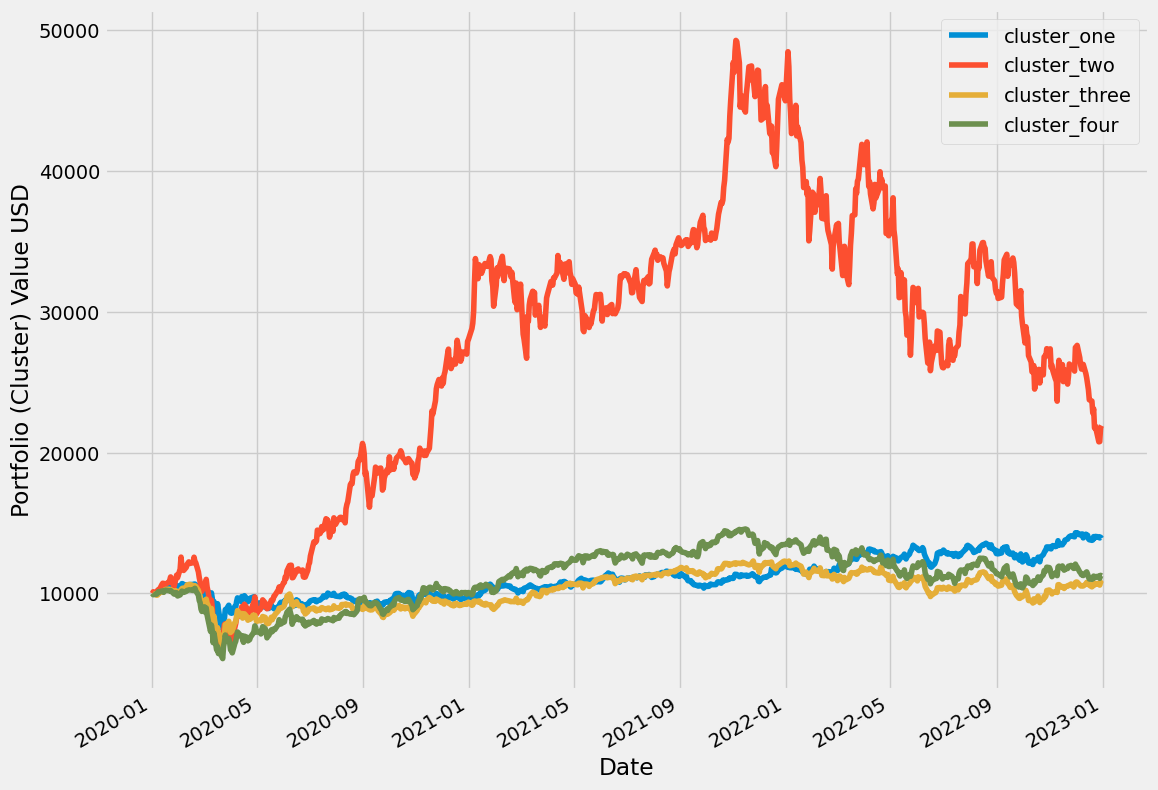

In [14]:
plt.style.use('fivethirtyeight')
final_df.plot(figsize=(12,10))
plt.ylabel('Portfolio (Cluster) Value USD')

In [16]:
stocks_list = []
for i in portfolios:
  a = i['Stock_Name'].to_list()
  stocks_list.append(a)

random_portfolios = {beta_clusters[i]: stocks_list[i] for i in range(len(beta_clusters))}
random_portfolios

{'cluster_one': ['NI', 'LLY', 'ED', 'PNW', 'PCAR'],
 'cluster_two': ['TSLA', 'BBWI', 'RCL', 'KLAC', 'TER'],
 'cluster_three': ['NDSN', 'NTRS', 'ACGL', 'AMT', 'ESS'],
 'cluster_four': ['LKQ', 'TFC', 'MET', 'AXP', 'CRM']}

In [17]:
total_return = (final_df.iloc[-1, :] / final_df.iloc[0, :] - 1) * 100
total_return = total_return.to_frame()
total_return.columns = ['Return']
total_return

,Return
cluster_one,39.009061
cluster_two,119.211852
cluster_three,6.909336
cluster_four,12.424002


In [18]:
total_return_USD = final_df.iloc[-1, :] - final_df.iloc[0, :]
total_return_USD = total_return_USD.to_frame()
total_return_USD.columns = ['Return_USD']
total_return_USD

,Return_USD
cluster_one,3900.906059
cluster_two,11921.185190
cluster_three,690.933551
cluster_four,1242.400204


In [19]:
stats = final_df.describe().T
stats.drop(['25%', '50%', '75%', 'count'], inplace=True, axis=1)
stats['median'] = final_df.median()
round(stats)

,mean,std,min,max,median
cluster_one,11085.0,1406.0,7480.0,14311.0,10876.0
cluster_two,27201.0,10488.0,5902.0,49269.0,29850.0
cluster_three,10247.0,1186.0,6238.0,12305.0,10422.0
cluster_four,11074.0,1998.0,5374.0,14577.0,11422.0


In [20]:
daily_profit = final_df.diff()
daily_profit.fillna(0, inplace=True)
stats_profit = daily_profit.describe().T
stats_profit.drop(['25%', '50%', '75%', 'count'], inplace=True, axis=1)
stats_profit['median'] = daily_profit.median() 
round(stats_profit)

,mean,std,min,max,median
cluster_one,5.0,154.0,-1083.0,938.0,11.0
cluster_two,16.0,837.0,-3727.0,3487.0,57.0
cluster_three,1.0,166.0,-1457.0,721.0,6.0
cluster_four,2.0,206.0,-1180.0,882.0,7.0


[]

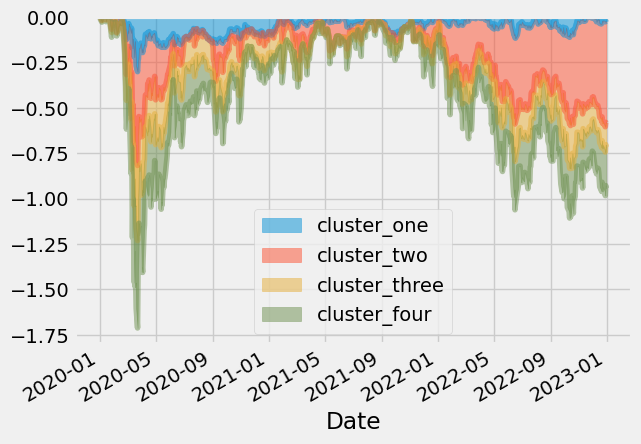

In [21]:
daily_percentage = final_df.pct_change()
daily_percentage.fillna(0, inplace=True)
cumulative = (daily_percentage + 1).cumprod()
rolling_max = np.maximum.accumulate(cumulative)
return_ = (cumulative-rolling_max) / rolling_max

chart = return_.plot(kind='area', alpha=0.5)
chart.plot(figsize=(20,15))